In [34]:
from si import *

# Slow term search using KS statistic on energy spectrum

### Goal: look at the energy spectrum very late in the fill, compare with rolling omega_a period, see if we can see anything strange

---


In [35]:
# f = r.TFile("./data/run2c_pileup_corrected_non.root")
f = r.TFile("./data/results_clustersAndCoinc_unrandomized_July7_pileup_corrected.root")
# f = r.TFile("./data/results_clustersAndCoinc_randomized_July7_pileup_corrected.root")
f.cd("clustersAndCoincidences")
f.ls()

TFile**		./data/results_clustersAndCoinc_unrandomized_July7_pileup_corrected.root	
 TFile*		./data/results_clustersAndCoinc_unrandomized_July7_pileup_corrected.root	
  TDirectoryFile*		clustersAndCoincidences	clustersAndCoincidences
   KEY: TH3D	uncorrected;1	uncorrected
   KEY: TH3D	corrected;1	corrected
   KEY: TH2I	triples;1	triples
   KEY: TH2I	quadruples;1	quadruples
   KEY: TH1I	ctag;1	ctag
  KEY: TDirectoryFile	clustersAndCoincidences;1	clustersAndCoincidences


In [36]:
h = f.Get("clustersAndCoincidences/corrected").Clone()

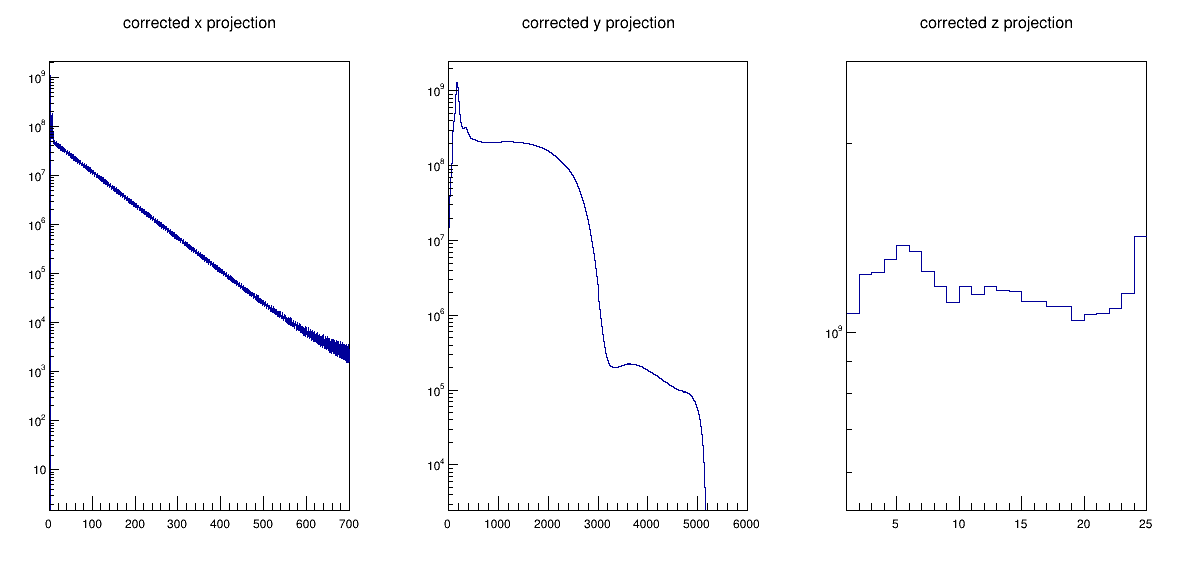

In [37]:
c = r.TCanvas("c","c",1200,600)
c.Divide(3)
for i,xi in enumerate(['x','y','z']):
    c.cd(i+1)
    h.Project3D(xi).Draw()
    r.gPad.SetLogy()
c.Draw()

In [38]:
omega_a_period = 4.37 # microseconds

In [39]:
width = h.GetXaxis().GetBinWidth(10)
print(width)
print(omega_a_period/width)
print(width*29)

0.14919011082693948
29.291485714285713
4.3265132139812446


### We only care about things which make it into our omega_a fits, so we can ignore everything below a certain energy

In [40]:
eLow = 2000
eHigh = 3100

tlow = 25
thigh = 400

In [41]:
h.GetYaxis().SetRangeUser(eLow,eHigh)

### Lets get our reference spectrum

In [42]:
nperiods = 50
thigh1 = 400
thigh2 = thigh1 + nperiods * omega_a_period
print(thigh1, thigh2)
# thigh2 = 700 #change to N exact g-2 periods

h.GetXaxis().SetRangeUser(thigh1, thigh2)

ref_spectrum = h.Project3D("y").Clone("ref_spectrum")
ref_spectrum.Scale(1/ref_spectrum.Integral())

400 618.5


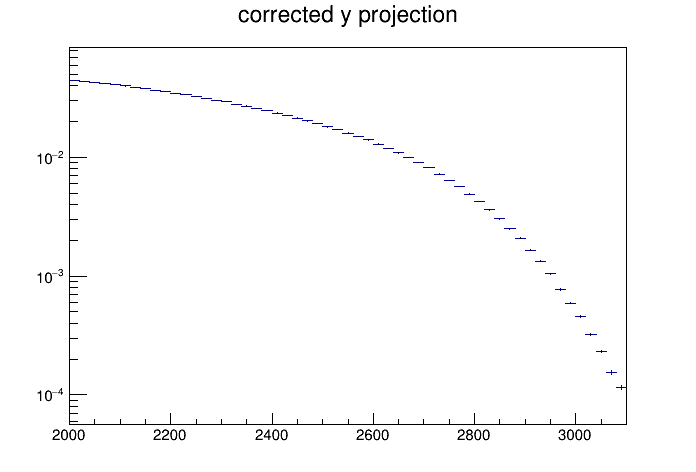

In [43]:
c = r.TCanvas()
ref_spectrum.Draw()
c.SetLogy()
c.Draw()

---

### Use root chi^2 test to compare the two histograms
https://root.cern.ch/doc/master/classTH1.html#a6c281eebc0c0a848e7a0d620425090a5

In [48]:
%%time

hists = []
times = []
ks = []
for bini in range(h.GetNbinsX()):
    bincenter = h.GetXaxis().GetBinCenter(bini)
    if(bincenter < tlow or bincenter > thigh):
        continue
    if(bini % 1000 == 0):
        print(bini)
    t1 = bincenter - omega_a_period/2
    t2 = bincenter + omega_a_period/2
    h.GetXaxis().SetRangeUser(t1,t2)
    hi = h.Project3D("y").Clone("h_"+str(bini))
    hi.Scale(1/hi.Integral())
    hists.append(hi.Clone())
    times.append(bincenter)
    ks.append( ref_spectrum.Chi2Test(hi,"UU NORM CHI2/NDF") )
    

1000
2000
CPU times: user 2.25 s, sys: 18.1 ms, total: 2.27 s
Wall time: 2.24 s


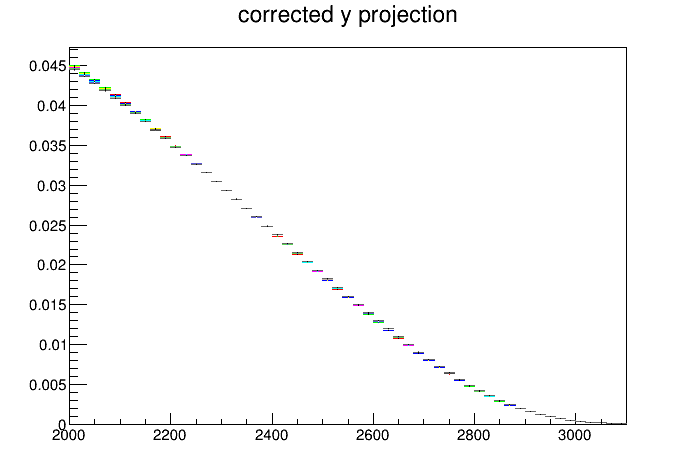

In [49]:
c = r.TCanvas()
for i, hi in enumerate(hists):
    hi.SetLineColor(i+2)
    if(i < 1):
        hi.Draw()
    else:
        hi.Draw("SAME")
    if(i > 10):
        break
# c.SetLogy()
c.Draw()

In [12]:
print(times[:10])
print(ks[:10])

[25.1385336743393, 25.28772378516624, 25.43691389599318, 25.58610400682012, 25.735294117647058, 25.884484228473998, 26.033674339300937, 26.182864450127877, 26.332054560954816, 26.481244671781756]
[6.633929541389955, 4.9511443102094255, 3.3887212586622844, 2.2020072782689444, 1.4687462583280715, 1.1126935995442058, 1.0762724382002768, 1.2823319517924534, 1.5900126407633992, 1.9141582215714454]


In [13]:
npoints = 10000
nsamples = 500000
# df_sim = pandas.read_csv("./data/monte_carlo_chiSquare_"+str(npoints)+"_points_"+str(nsamples)+"_samples.csv", delimiter="|")
df_sim = pandas.read_csv("./data/monte_carlo_chiSquare_omegaA_1000_points_5000000_samples.csv", delimiter="|")
df_sim.head()

,Unnamed: 0,time,chisquare
0,0,30.000000,513.913267
1,1,30.620621,583.739068
2,2,31.241241,335.707889
3,3,31.861862,61.078265
4,4,32.482482,0.711406


In [14]:
getBlinded = Blinders(FitType.Omega_a, 'Second verse, same as the first')

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [15]:
def peak_fit_omega_a_decay(x,p):
    time = x[0]
    
    c = p[0]
    A_a = p[1]
    R = p[2]
    omega_a = getBlinded.paramToFreq(R)
    phi_a = p[3]
    A_a2 = p[4]    
    phi_a2 = p[5]
    
    tau = p[6]

    slope = p[7]
    
    A_other = p[8]
    omega_other = p[9]
    phi_other = p[10]
    
    tau2 = p[11]
    
    return (      (  A_a*( 1 +  math.sin(2*omega_a*time   + phi_a) )*( math.exp(-time/(tau*2)))
                  + A_a2*( 1 + math.sin(omega_a*time   + phi_a2) )*( math.exp(-time/(tau)))
                  + c )#*math.exp(-time/tau3)
#                   + offset
#                   + math.exp(-time/tau)*( Aenv*math.sin(omega_a*time + phi_a))
#                 + slope*time
                + A_other*( 1 + math.sin(omega_other*time   + phi_other) )*math.exp(-time/tau2)
           )

func = r.TF1("func", peak_fit_omega_a_decay, 30,350,12)
func.SetParNames('C', 
                 'A_{a}','R','#phi_{a}',
                 'A_{a-2}', '#phi_{a-2}', 
                 '#tau', 
#                  'A_{envelope}', "#tau_{2}", "#tau_{3}", 
                 "slope", "A_{other}", "#omega_{other}")
func.SetParName(10,"#phi_{other}")
func.SetParName(11,"#tau_2")

func.SetParLimits(6,1,1000)
func.SetParLimits(11,1,10000)
# func.SetParLimits(9,1,1000)

# func.FixParameter(3,0)
func.SetLineColor(6)
func.SetNpx(1000)
func.SetParameters(3.574305720548232, 
                   3.0267903032177457, -76.13765229344928, -0.011588112943985202, 
                   -2.3664493492975156, 7.057001755371655, 
                   263.88671165705205, 
                   -0.00052654730319,
                   1.233, 0.007)
func.SetParameter(10, math.pi)
func.SetParameter(11, 100)

In [16]:
fit = fitVector(times, ks, func, nFit=2)

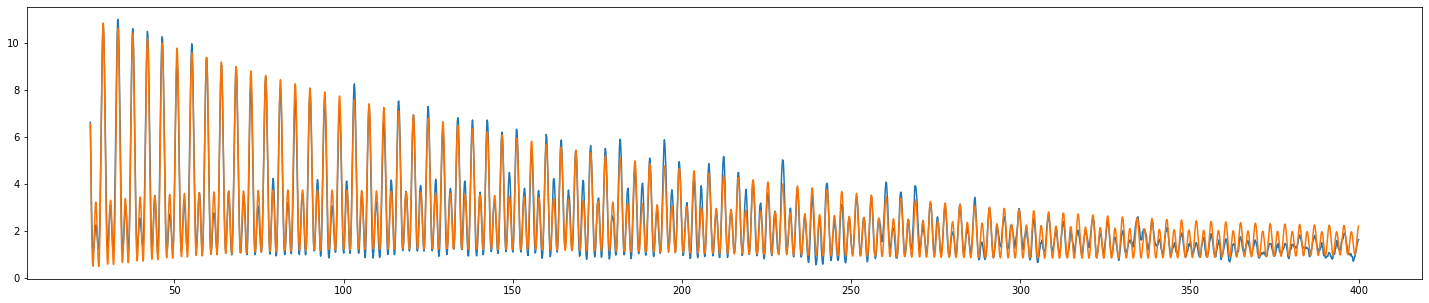

In [17]:
fig,ax = plt.subplots(figsize=(25,5))
# fit.f.SetParameters(1,0,30,-5,.05,0)
fit.drawFitResult(ax, 10000)
plt.plot(times,ks,"-")
plt.show()

In [18]:
print(fit.pars)

[22.362083607317018, 3.380073539010009, -71.3448445599665, -0.03165851448392834, -4.9417535131888215, 7.046669416119909, 109.6717043424262, -0.00052654730319, -26.833766126088513, 0.0020076766070383314, 5.896008701820104, 697.4097250052586]


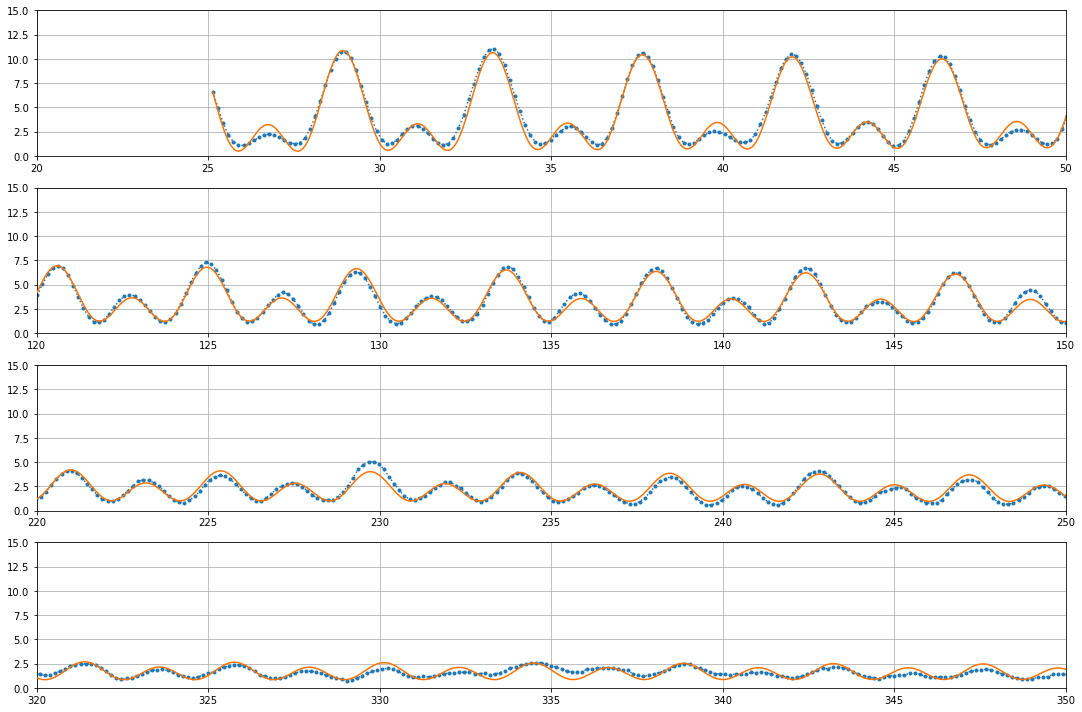

In [28]:
fig,ax = plt.subplots(4,1,figsize=(15,10))
for i,axi in enumerate(ax):
    axi.plot(times,ks,".:")
    axi.set_xlim(20+(100*i),50+(100*i))
    fit.drawFitResult(axi, 10000)
    axi.grid()
    axi.set_ylim(0,15)
# plt.yscale("log")
plt.tight_layout()
plt.show()

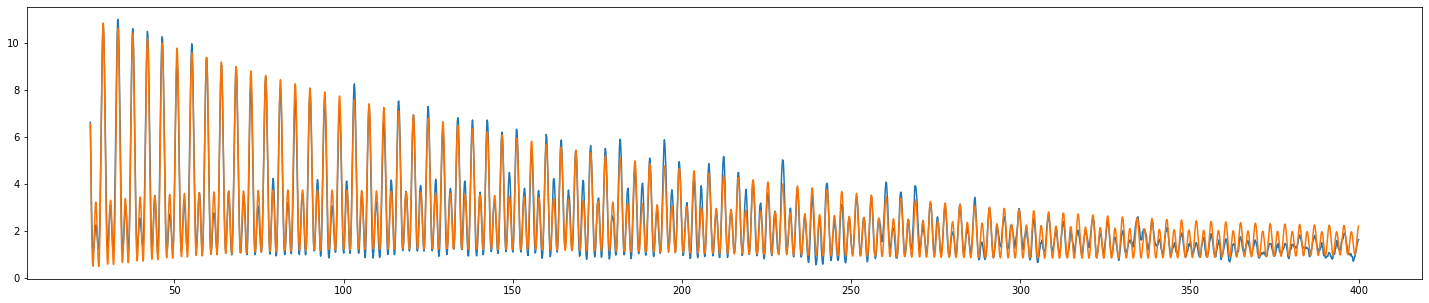

In [20]:
fig,ax = plt.subplots(figsize=(25,5))
fit.drawFitResult(ax, 10000)
plt.plot(times,ks,"-")
plt.show()

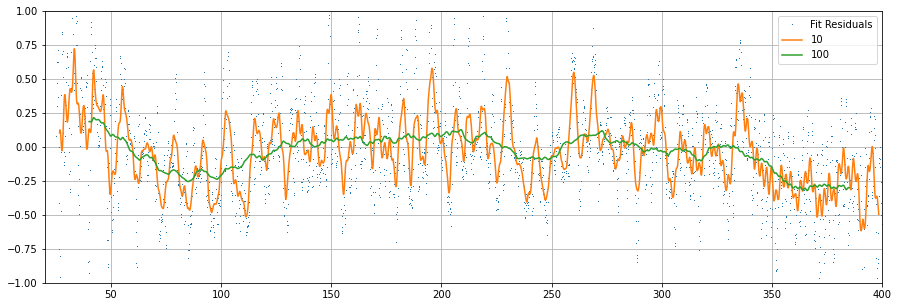

In [21]:
fig,ax = plt.subplots(figsize=(15,5))
fit.plotResiduals(ax, 2,",",runningAverage=1)
fit.plotResiduals(ax, 2,"-",runningAverage=10,labeli="10")
fit.plotResiduals(ax, 2,"-",runningAverage=100,labeli="100")
plt.xlim(20,400)
plt.ylim(-1,1)
plt.grid()
plt.legend(loc=1)
plt.show()

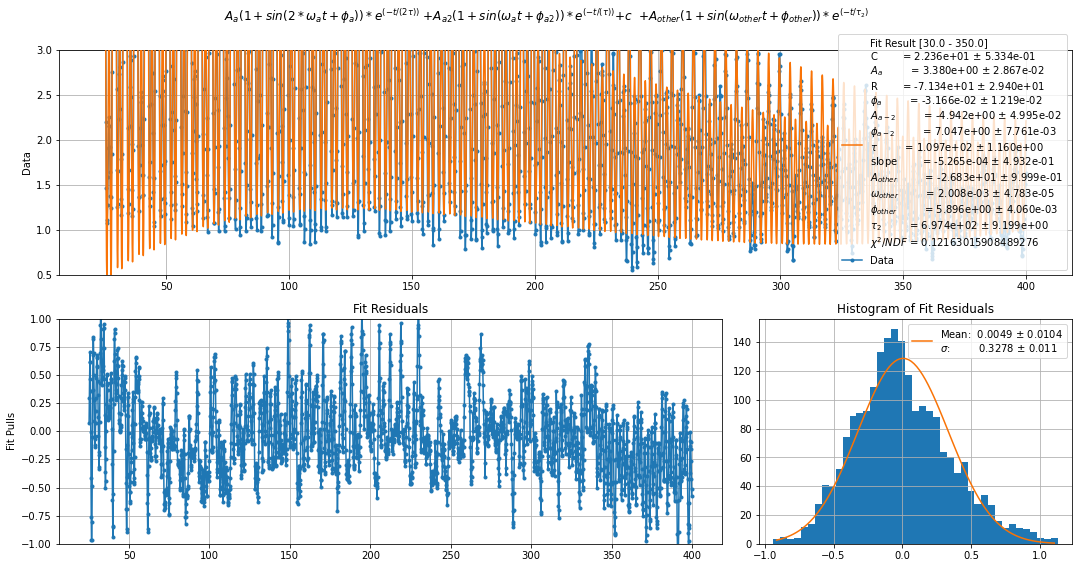

In [41]:
fig, ax = fit.draw(draw_confidence_intervals=False)
# plt.suptitle(r" Fit: $c + mt + e^{-t/\tau}*A cos(\omega t + \phi)$", y=1.02, fontsize=18)
plt.suptitle(( r"  $A_a ( 1 + sin(2*\omega_a t   + \phi_a) )* e^{(-t/(2 \tau ))}$"+ 
                  r" $ + A_{a2} ( 1 + sin(\omega_a t   + \phi_{a2}) )* e^{(-t/(\tau))} $"+
                  r"$+ c$ "+ #*math.exp(-time/tau3)
#                   + offset
#                   + math.exp(-time/tau)*( Aenv*math.sin(omega_a*time + phi_a))
#                 + slope*time
                r" $ + A_{other} ( 1 + sin(\omega_{other} t   + \phi_{other}) )*e^{(-t/\tau_2 )} $"))
ax[1].set_ylim(-1,1)
ax[0].set_ylim(0.5,3)
plt.show()

Restricting range of FFT to: [20, 300]


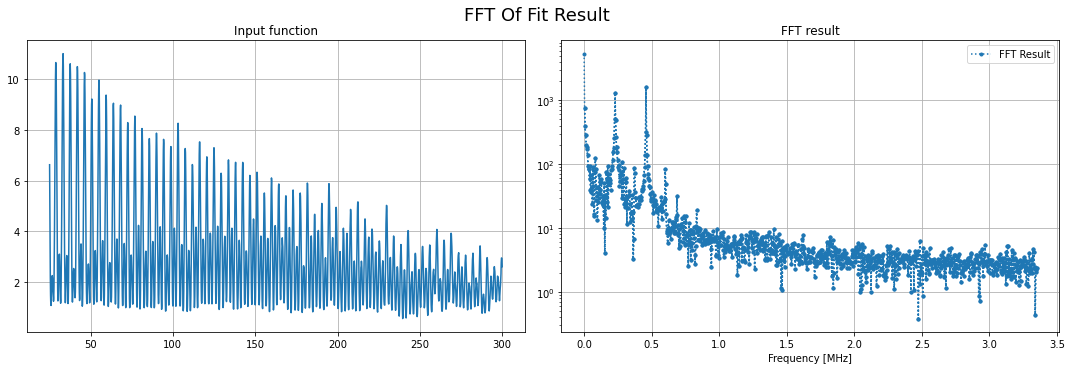

In [23]:
ding = fit.fft([20,300],0)

Restricting range of FFT to: [20, 300]


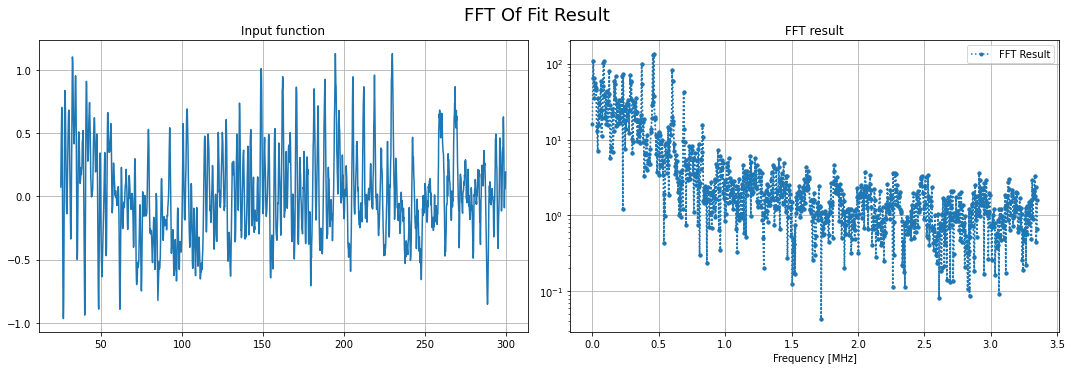

In [24]:
ding = fit.fft([20,300],1)

In [25]:
len(ding[0])/2

921.5

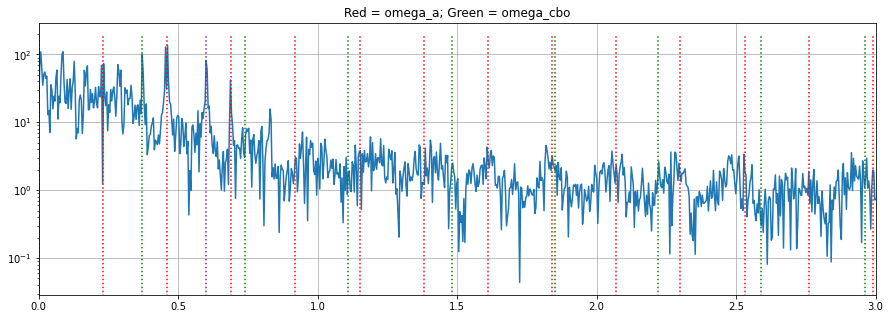

In [26]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(ding[0][:int(len(ding[0])/2)], np.abs(ding[1][:int(len(ding[0])/2)]))
plt.xlim(0,3)
omega_a = 0.23
for i in range(15):
    plt.plot([i*omega_a, i*omega_a], [0,1.41*max(np.abs(ding[1][:int(len(ding[0])/2)]) )], "r:")
omega_cbo = 0.37
for i in range(15):
    plt.plot([i*omega_cbo, i*omega_cbo], [0,1.41*max(np.abs(ding[1][:int(len(ding[0])/2)]) )], "g:")
plt.plot([omega_cbo+omega_a,omega_cbo+omega_a], [0,1.41*max(np.abs(ding[1][:int(len(ding[0])/2)]) )], ":", color="xkcd:purple")
plt.grid()
plt.yscale("log")
plt.title("Red = omega_a; Green = omega_cbo")
plt.show()